# Exploring Feature Selection

            Specs          Score
13            ram  931267.519053
11      px_height   17363.569536
0   battery_power   14129.866576
12       px_width    9810.586750
8       mobile_wt      95.972863
6      int_memory      89.839124
15           sc_w      16.480319
16      talk_time      13.236400
4              fc      10.135166
14           sc_h       9.614878
[0.06127717 0.01977397 0.03196769 0.01902065 0.03202722 0.01743671
 0.03583144 0.03319799 0.03542693 0.03248975 0.03321755 0.0464652
 0.04929767 0.40346985 0.03232404 0.03283296 0.03338639 0.01336495
 0.01801273 0.01917913]


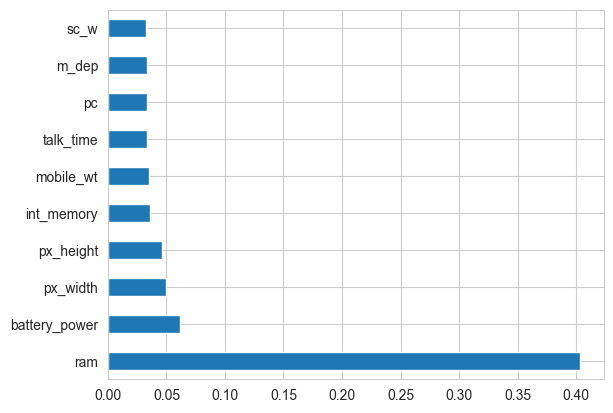

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
data = pd.read_csv("train.csv")
X = data.iloc[:,0:20] #independent columns
y = data.iloc[:,-1] #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] #naming the dataframe columns
print(featureScores.nlargest(10,'Score')) #print 10 best features
X = data.iloc[:,0:20] #independent columns
y = data.iloc[:,-1] #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


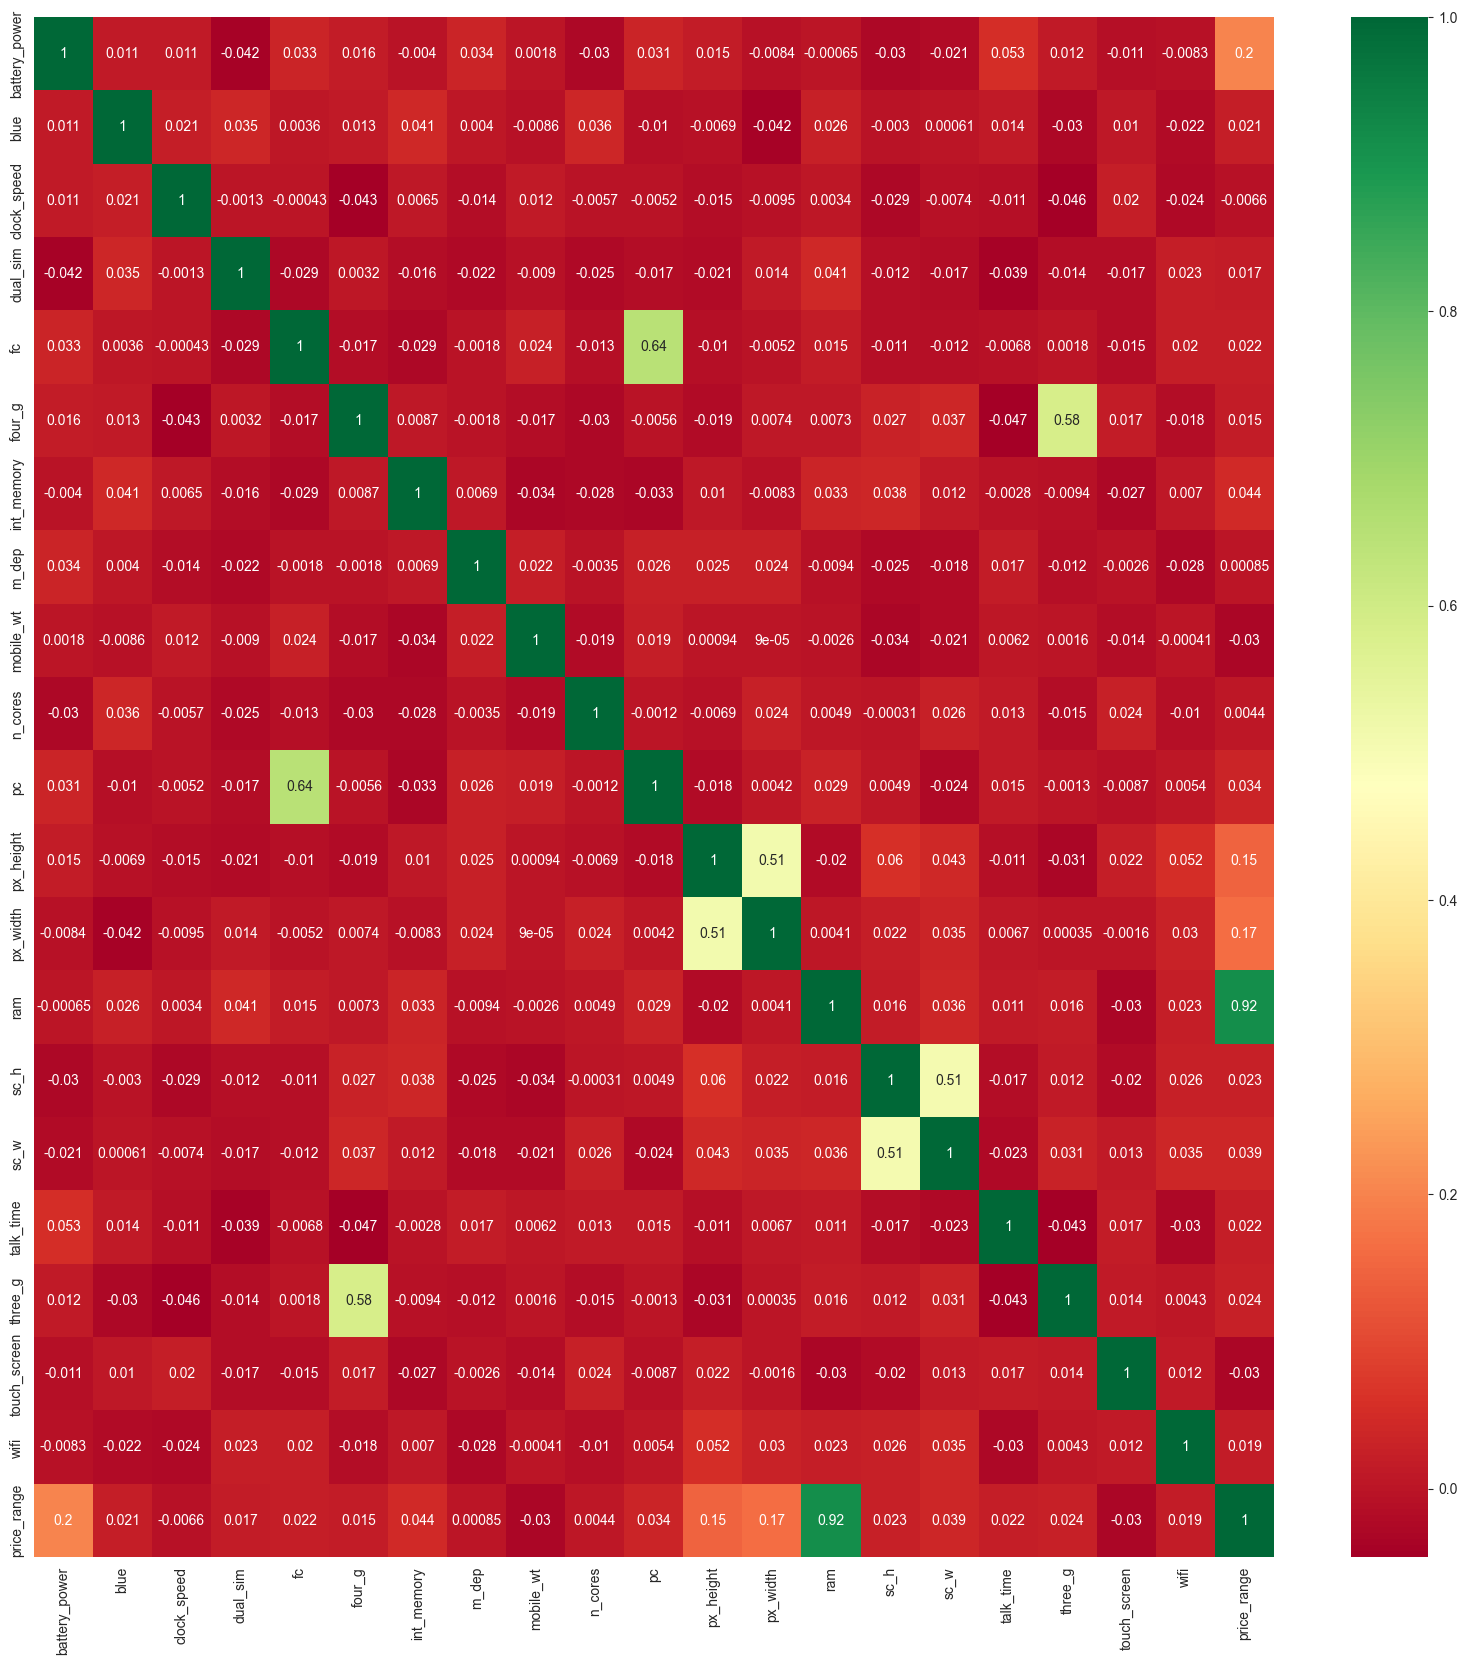

In [5]:
import seaborn as sns
X = data.iloc[:,0:20] #independent columns
y = data.iloc[:,-1] #target column i.e price range
#get correlations of each features in dataset
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Classification Model Development

### Import necessary libraries, load the dataset, and perform initial checks

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Load the data
glass = pd.read_csv('glass.csv')

# Show basic info
print(glass.info())
print(glass.head())
print()

# Check the distribution of the target variable
print("Target variable distribution:")
print(glass['type'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   idno    214 non-null    int64  
 1   RI      214 non-null    float64
 2   Na      214 non-null    float64
 3   Mg      214 non-null    float64
 4   Al      214 non-null    float64
 5   Si      214 non-null    float64
 6   K       214 non-null    float64
 7   Ca      214 non-null    float64
 8   Ba      214 non-null    float64
 9   Fe      214 non-null    float64
 10  type    214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB
None
   idno       RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  type
0     1  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1     2  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2     3  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3     4  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  

### Data Preprocessing

In [5]:
# Drop the ID column
glass = glass.drop('idno', axis=1)

# Check for missing values
print("Missing values in each column:")
print(glass.isnull().sum())
print()

# Check for duplicates
print("Number of duplicate rows found:", glass.duplicated().sum())

# Remove duplicates if any
glass = glass.drop_duplicates()

# Check for duplicates again
print("Number of duplicate rows after duplicates removed:", glass.duplicated().sum())

# Remove outliers using Z-score method
from scipy import stats
z_scores = np.abs(stats.zscore(glass.select_dtypes(include=[np.number])))
threshold = 3
outliers = (z_scores > threshold).any(axis=1)
print("Number of outliers found:", np.sum(outliers))
glass = glass[~outliers]
print("Number of rows after outlier removal:", glass.shape[0])

Missing values in each column:
RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
type    0
dtype: int64

Number of duplicate rows found: 1
Number of duplicate rows after duplicates removed: 0
Number of outliers found: 20
Number of rows after outlier removal: 193


### Test, training, validation through 8-fold cross-validation, and evaluation of the model

In [6]:
# Separate features and target
X = glass.drop('type', axis=1)
y = glass['type']

# Train-test split (80/20, stratified, seed=10)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, stratify=y)

selector = SelectKBest(score_func=chi2, k=5)
selector.fit(X_train, y_train)
top5_uni = X.columns[selector.get_support()].tolist()
print('Top 5 Univariate Features:', top5_uni)

rf = ExtraTreesClassifier(random_state=10)
rf.fit(X_train, y_train)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top5_imp = importances.sort_values(ascending=False).head(5).index.tolist()
print('Top 5 Important Features:', top5_imp)

correlations = X_train.corrwith(y_train).abs()
top5_corr = correlations.sort_values(ascending=False).head(5).index.tolist()
print('Top 5 Correlated Features:', top5_corr)
print()


def evaluate_model(X_tr, X_te, y_tr, y_te, features, label):
    gnb = GaussianNB()
    gnb.fit(X_tr[features], y_tr)
    y_pred = gnb.predict(X_te[features])
    cv = KFold(n_splits=8, shuffle=True, random_state=10)
    cv_scores = cross_val_score(gnb, X_tr[features], y_tr, cv=cv, scoring='accuracy')
    print(f'--- {label} ---')
    print('Test Accuracy:', accuracy_score(y_te, y_pred))
    print('Test Precision:', precision_score(y_te, y_pred, average="weighted", zero_division=0))
    print('Test Recall:', recall_score(y_te, y_pred, average="weighted", zero_division=0))
    print('Test F1:', f1_score(y_te, y_pred, average="weighted", zero_division=0))
    print('CV Mean Accuracy:', np.mean(cv_scores))
    print('Classification Report:\n', classification_report(y_te, y_pred, zero_division=0))

evaluate_model(X_train, X_test, y_train, y_test, X.columns, 'All Features')
evaluate_model(X_train, X_test, y_train, y_test, top5_uni, 'Univariate Selection')
evaluate_model(X_train, X_test, y_train, y_test, top5_imp, 'Feature Importance')
evaluate_model(X_train, X_test, y_train, y_test, top5_corr, 'Correlation')


Top 5 Univariate Features: ['Mg', 'Al', 'K', 'Ca', 'Ba']
Top 5 Important Features: ['Mg', 'Al', 'Ca', 'RI', 'K']
Top 5 Correlated Features: ['Mg', 'Ba', 'Al', 'Na', 'K']

--- All Features ---
Test Accuracy: 0.6666666666666666
Test Precision: 0.6954918719624603
Test Recall: 0.6666666666666666
Test F1: 0.6637777058534421
CV Mean Accuracy: 0.5733552631578946
Classification Report:
               precision    recall  f1-score   support

           1       0.59      0.71      0.65        14
           2       0.78      0.50      0.61        14
           3       0.33      0.33      0.33         3
           5       0.50      1.00      0.67         2
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         5

    accuracy                           0.67        39
   macro avg       0.70      0.76      0.71        39
weighted avg       0.70      0.67      0.66        39

--- Univariate Selection ---
Test Accuracy: 0.6666666666666666
Test Precisi